In [1]:
import pints
import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Create own Logistic Model with pints Forward Model
class MyLogisticModel(pints.ForwardModel):
    def __init__(self, initial_population_size=2):
        super(MyLogisticModel, self).__init__()
        self._p0 = float(initial_population_size)

    def n_parameters(self):
        """
        Returns the dimension of the parameter space.
        """
        return 2

    def simulate(self, parameters, times):
        """
        Runs a forward simulation with the given ``parameters`` and returns a
        time-series with data points corresponding to the given ``times``.
        Returns a sequence of length ``n_times`` (for single output problems)
        or a NumPy array of shape ``(n_times, n_outputs)`` (for multi-output
        problems), representing the values of the model at the given ``times``.
        Parameters
        ----------
        parameters
            An ordered sequence of parameter values.
        times
            The times at which to evaluate. Must be an ordered sequence,
            without duplicates, and without negative values.
            All simulations are started at time 0, regardless of whether this
            value appears in ``times``.
        """
        r, k = [float(x) for x in parameters]
        times = np.asarray(times)
        if np.any(times < 0):
            raise ValueError('Negative times are not allowed.')
        if self._p0 == 0 or k < 0:
            return np.zeros(times.shape)

        exp = np.exp(-r * times)
        c = (k / self._p0 - 1)

        values = k / (1 + c * exp)

        return values
        

    def n_outputs(self):

        """
        Returns the number of outputs this model has. The default is 1.
        """
        return 1


In [3]:
# Create logistic model
model = MyLogisticModel()

# Select the parameters to run the model to obtain data
true_parameters = [0.015, 500]

# Run the model for the `times` timeframe
times = np.linspace(0, 1000, 400)

# Run deterministic model with true parameters
org_values = model.simulate(true_parameters, times)

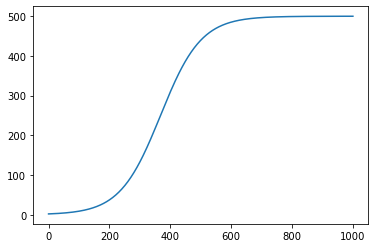

In [4]:
plt.plot(times, org_values)

In [5]:
# Add noise over the smooth data (here is Gaussian noise)
noise = 25
values = org_values + np.random.normal(0, noise, org_values.shape)

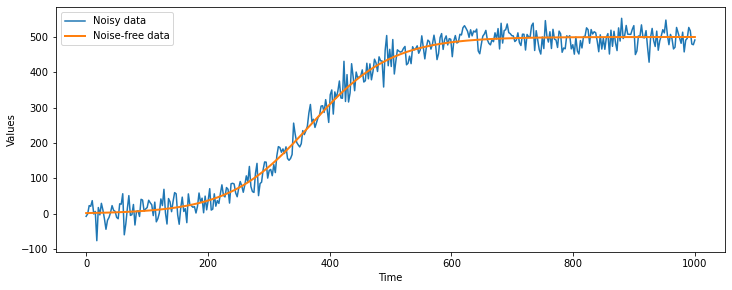

In [6]:
plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

We set up the inference for this logistic model

In [7]:
# Set up my log-likelihood object for the inference using the pints.LogPDF
class MyGaussianLogLikelihood(pints.LogPDF):
    r"""
    Calculates a log-likelihood assuming independent Gaussian noise at each
    time point, and adds a parameter representing the standard deviation
    (sigma) of the noise on each output.
    For a noise level of ``sigma``, the likelihood becomes:
    .. math::
        L(\theta, \sigma|\boldsymbol{x})
            = p(\boldsymbol{x} | \theta, \sigma)
            = \prod_{j=1}^{n_t} \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(
                -\frac{(x_j - f_j(\theta))^2}{2\sigma^2}\right)
    leading to a log likelihood of:
    .. math::
        \log{L(\theta, \sigma|\boldsymbol{x})} =
            -\frac{n_t}{2} \log{2\pi}
            -n_t \log{\sigma}
            -\frac{1}{2\sigma^2}\sum_{j=1}^{n_t}{(x_j - f_j(\theta))^2}
    where ``n_t`` is the number of time points in the series, ``x_j`` is the
    sampled data at time ``j`` and ``f_j`` is the simulated data at time ``j``.
    For a system with ``n_o`` outputs, this becomes
    .. math::
        \log{L(\theta, \sigma|\boldsymbol{x})} =
            -\frac{n_t n_o}{2}\log{2\pi}
            -\sum_{i=1}^{n_o}{ {n_t}\log{\sigma_i} }
            -\sum_{i=1}^{n_o}{\left[
                \frac{1}{2\sigma_i^2}\sum_{j=1}^{n_t}{(x_j - f_j(\theta))^2}
             \right]}
    Extends :class:`ProblemLogLikelihood`.
    Parameters
    ----------
    problem
        A :class:`SingleOutputProblem` or :class:`MultiOutputProblem`. For a
        single-output problem a single parameter is added, for a multi-output
        problem ``n_outputs`` parameters are added.
    """

    def __init__(self, model, values, times):
        super(MyGaussianLogLikelihood, self).__init__()

        # Get number of times, number of outputs
        self._model = model
        self._times = times.tolist()
        self._nt = len(self._times)
        self._no = 1
        self._values = values

        # Add parameters to problem
        self._n_parameters = 2 + self._no

        # Pre-calculate parts
        self._logn = 0.5 * self._nt * np.log(2 * np.pi)

    def __call__(self, x):
        sigma = np.asarray(x[-self._no:])
        if any(sigma <= 0):
            return -np.inf
        error = self._values - self.evaluate(x[:-self._no])
        return np.sum(- self._logn - self._nt * np.log(sigma)
                      - np.sum(error**2, axis=0) / (2 * sigma**2))

    def evaluate(self, parameters):
        """
        Runs a simulation using the given parameters, returning the simulated
        values as a NumPy array of shape ``(n_times,)``.
        """
        y = np.asarray(self._model.simulate(parameters, self._times))
        return y.reshape((self._nt,))

    def n_parameters(self):
        """
        Returns the dimension of the parameter space.
        """
        return self._n_parameters

log_likelihood = MyGaussianLogLikelihood(model, values, times)

In [8]:
# Add noise to the paramaters of the inference problem
true_parameters += [noise]
print(true_parameters)

[0.015, 500, 25]


Create LogPrior and add LogLikelihood to create the LogPosterior

In [9]:
log_prior = pints.UniformLogPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
    )

In [10]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [11]:
# Starting points for the inference
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [12]:
# Run the in ference for the initial guesses
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0.333     0         0.333      0:00.0
3     12     0.25      0         0.25       0:00.0
20    63     0.0952    0         0.0952     0:00.0
40    123    0.0976    0.0488    0.0488     0:00.0
60    183    0.082     0.0328    0.0328     0:00.0
80    243    0.0617    0.0247    0.037      0:00.0
100   303    0.0495    0.0297    0.0396     0:00.0
120   363    0.0661    0.0248    0.0331     0:00.0
140   423    0.0567    0.0213    0.0284     0:00.0
160   483    0.0497    0.0186    0.0248     0:00.0
180   543    0.0442    0.0166    0.0221     0:00.1
Initial phase completed.
200   603    0.039801  0.0149    0.0299     0:00.1
220   663    0.0498    0.0317    0.0407     0:00.1
240   723    0.0913    0.0664    0.0747     0:00.1
260   783   

###  Plot the chains to observe how well they mix

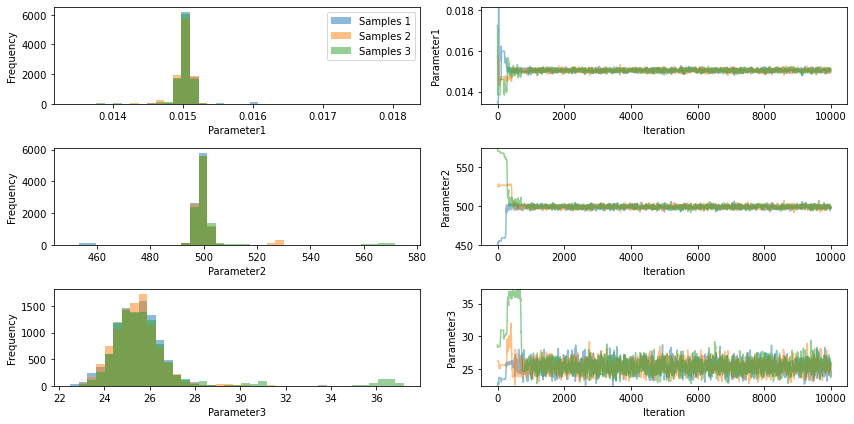

In [13]:
import pints.plot
pints.plot.trace(chains)
plt.show()

The 3 chains are well mixing based of the histogram plots, and start looking alike after 1000 iterations for all three parameters of the inference problem -- consider 1500 the burn-in period

In [14]:
chain = chains[0]
chain = chain[1500:]

Plot the autocorrelation graphs; the low levels of the autocorrelation lead us to believe that after running the chains for a while, the samples act almost like independent samples from the posterior distibution.

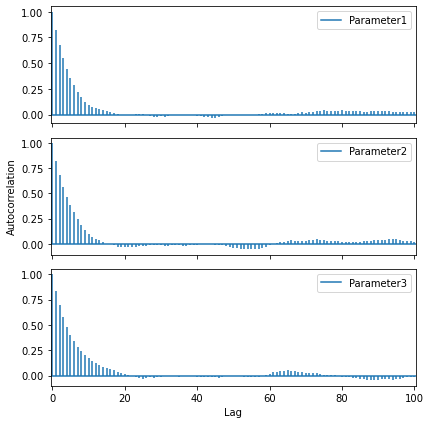

In [15]:
pints.plot.autocorrelation(chain)
plt.show()

Compare the hostogram of the chains (without the burn-in observations) with the true values

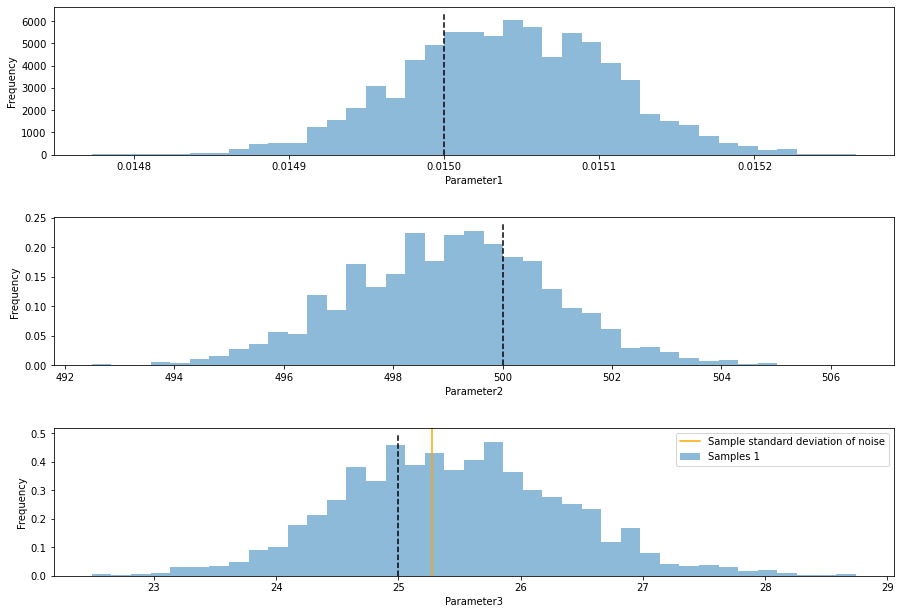

In [16]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Add thinning to the chain; it not only increases the spead, but also decreases the autocorrealtion between the samples (each next observation is dependent on the current position -- we expect that by keeping only each other 10th observation, they act a bit more like independent draws from the posterior distribution)

In [17]:
chain = chain[::10]

Plot pairwise cuts throught the posterior distribution (keep one parameter fixed) -- for all, but the combo of Param1 & Param2 we hit inside the region of highest probability

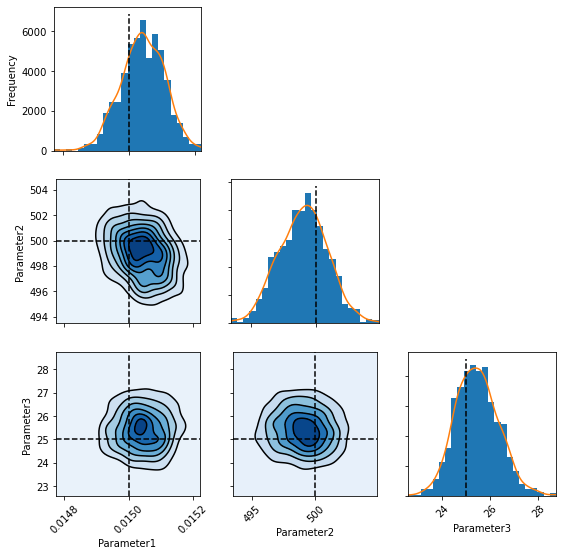

In [18]:
pints.plot.pairwise(chain, kde=True, ref_parameters=true_parameters)
plt.show()

We compare now the true values of the parameter to the log-posterior when keeping the other two parameters fixed; The last pannel of the noise illustrates that the issues arrise due to the fact that the noise in the sample biases the inference for the last parameter; hence why it is hard to infer it properly

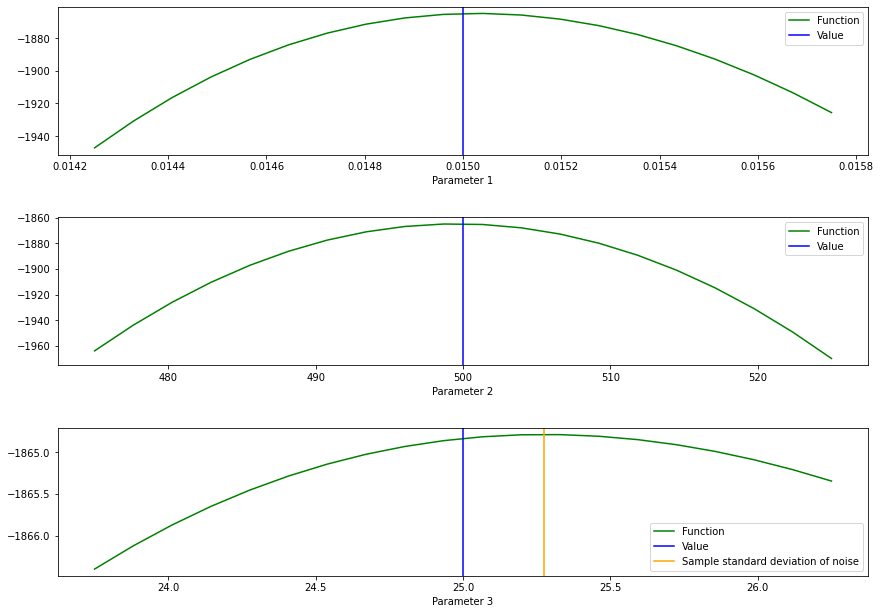

In [19]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

We plot now the true model versus the observed data, versus the model with the inferred parameter; the inferred and true model align really well

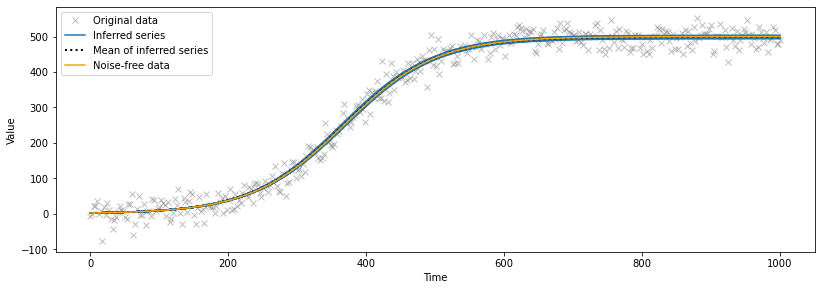

In [24]:
# Evaluate the model for all parameter sets in the samples
n_sample, n_param = chain.shape
thinning = max(1, int(n_sample / 200))

n_parameters = model.n_parameters()

i = 0
predicted_values = []
for params in chain[::thinning, :n_parameters]:
    predicted_values.append(model.simulate(params, times))
    i += 1
predicted_values = np.array(predicted_values)
mean_values = np.mean(predicted_values, axis=0)

# Guess appropriate alpha (0.05 worked for 1000 plots)
alpha = min(1, max(0.05 * (1000 / (n_sample / thinning)), 0.5))

# Plot prediction
fig, axes = plt.subplots(1, 1, figsize=(8, np.sqrt(1) * 3),
                            sharex=True)


plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(
    times, values, 'x', color='#7f7f7f', ms=6.5, alpha=0.5,
    label='Original data')
plt.plot(
    times, predicted_values[0], color='#1f77b4',
    label='Inferred series')
for v in predicted_values[1:]:
    plt.plot(times, v, color='#1f77b4', alpha=alpha)
plt.plot(times, mean_values, 'k:', lw=2,
            label='Mean of inferred series')

plt.legend()

plt.tight_layout()

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()
